In [39]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plots
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

pd.options.display.max_seq_items = 4000

In [40]:
# Importing dataset

ufc_prepoc_dataset = pd.read_csv("preprocessed_data.csv")
ufc_dataset = pd.read_csv("data.csv")

ufc_dataset = ufc_dataset.dropna().reset_index()
display(ufc_dataset)

,index,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,B_avg_KD,...,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,0,Adrian Yanez,Gustavo Lopez,Chris Tognoni,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Bantamweight,0.000000,...,0,1,0,0,Orthodox,170.18,177.80,135.0,31.0,27.0
1,1,Trevin Giles,Roman Dolidze,Herb Dean,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Middleweight,0.500000,...,0,3,0,0,Orthodox,182.88,187.96,185.0,32.0,28.0
2,4,Marion Reneau,Macy Chiasson,Mark Smith,2021-03-20,"Las Vegas, Nevada, USA",Blue,False,WomenBantamweight,0.125000,...,1,2,2,0,Orthodox,167.64,172.72,135.0,29.0,43.0
3,5,Leonardo Santos,Grant Dawson,Chris Tognoni,2021-03-20,"Las Vegas, Nevada, USA",Blue,False,Lightweight,0.000000,...,2,2,2,0,Orthodox,182.88,190.50,155.0,27.0,41.0
4,6,Song Kenan,Max Griffin,Keith Peterson,2021-03-20,"Las Vegas, Nevada, USA",Blue,False,Welterweight,0.046875,...,1,3,0,0,Orthodox,182.88,180.34,170.0,35.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3885,5759,Tito Ortiz,Evan Tanner,John McCarthy,2001-02-23,"Atlantic City, New Jersey, USA",Red,True,LightHeavyweight,0.000000,...,1,2,1,1,Orthodox,190.50,187.96,205.0,30.0,26.0
3886,5767,Chuck Liddell,Jeff Monson,Mario Yamasaki,2000-12-16,"Tokyo, Japan",Red,False,Middleweight,0.000000,...,1,0,0,1,Orthodox,187.96,193.04,205.0,29.0,30.0
3887,5799,Tito Ortiz,Wanderlei Silva,John McCarthy,2000-04-14,"Tokyo, Japan",Red,True,LightHeavyweight,0.500000,...,0,2,0,1,Orthodox,190.50,187.96,205.0,23.0,25.0
3888,5840,Jeremy Horn,Chuck Liddell,John McCarthy,1999-03-05,"Bay St. Louis, Mississippi, USA",Red,False,Middleweight,0.000000,...,0,0,0,0,Orthodox,185.42,187.96,185.0,29.0,23.0


Index(['Red', 'Blue', 'Draw'], dtype='object')

array([2397, 1424,   69])

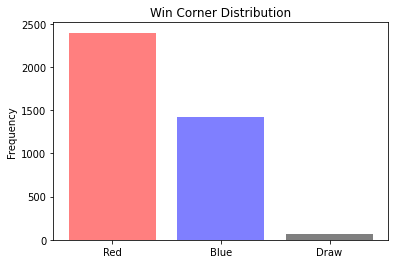

In [41]:
corner = ufc_dataset["Winner"].value_counts().index
display(corner)

counts = ufc_dataset["Winner"].value_counts().values
display(counts)

plt.title("Win Corner Distribution")
plt.ylabel("Frequency")
plt.bar(corner, counts, color=["red", "blue", "black"], linewidth=0.5, alpha = 0.5)
plt.show()

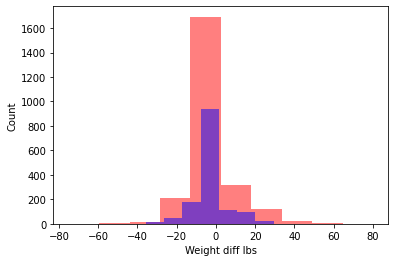

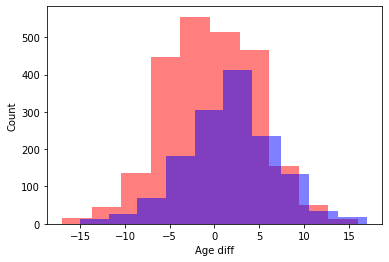

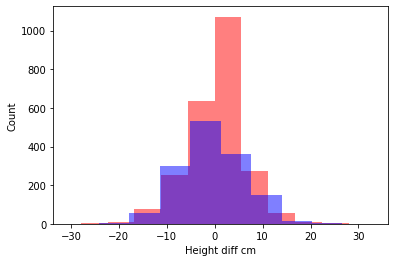

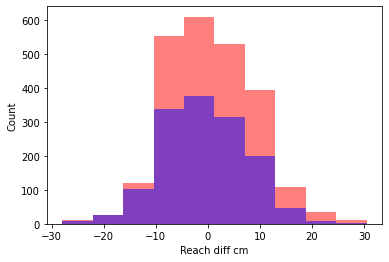

In [42]:
differences_df = pd.DataFrame()
differences_df["Winner"] = ufc_dataset["Winner"]
differences_df["Weight_diff_lbs"] = ufc_dataset["R_Weight_lbs"] - ufc_dataset["B_Weight_lbs"]
differences_df["Age_diff"] = ufc_dataset["R_age"] - ufc_dataset["B_age"]
differences_df["Height_diff_cm"] = ufc_dataset["R_Height_cms"] - ufc_dataset["B_Height_cms"]
differences_df["Reach_diff_cm"] = ufc_dataset["R_Reach_cms"] - ufc_dataset["B_Reach_cms"]

redwin_differences_df = differences_df[differences_df["Winner"] == "Red"]
bluewin_differences_df = differences_df[differences_df["Winner"] == "Blue"]

for i in differences_df.columns:
    if (i != "Winner"):
        plt.figure()
        plt.hist(redwin_differences_df[i], rwidth=1, color="red", label="No Of Red Wins", alpha = 0.5)
        plt.hist(bluewin_differences_df[i], rwidth=1, color="blue", label="No Of Blue Wins", alpha = 0.5)
        plt.xlabel(i.replace("_", " "))
        plt.ylabel("Count")
        plt.savefig(i+".png")

In [43]:
def Convert_Red_to_Yes(listt):
    for i in range(len(listt)):
        if listt[i] == "Red":
            listt[i] = "Yes"
        elif listt[i] == "Blue":
            listt[i] = "No"
        else:
            listt[i] = "Draw"
    return listt


def Convert_1_to_Yes(listt):
    for i in range(len(listt)):
        if listt[i] == "1":
            listt[i] = "Yes"
        elif listt[i] == "0":
            listt[i] = "No"
        else:
            listt[i] = "-1"
    return listt

In [44]:
# Research Question 1: Win Predictor

R_Weights = ufc_dataset["R_Weight_lbs"].tolist()
B_Weights = ufc_dataset["B_Weight_lbs"].tolist()

R_Reach = ufc_dataset["R_Reach_cms"].tolist()
B_Reach = ufc_dataset["B_Reach_cms"].tolist()

R_Height = ufc_dataset["R_Height_cms"].tolist()
B_Height = ufc_dataset["B_Height_cms"].tolist()

R_age = ufc_dataset["R_age"].tolist()
B_age = ufc_dataset["B_age"].tolist()
Winner = ufc_dataset["Winner"].tolist()

Fight_output = Winner.copy()
for i in range(len(Fight_output)):
    if Fight_output[i] == "Red":
        Fight_output[i] = 1 #Yes
    elif Fight_output[i] == "Blue":
        Fight_output[i] = 0 #No
    else:
        Fight_output[i] = -1 #Draw
        
Display_Fight_output =  Convert_Red_to_Yes(Winner.copy())     

# w.r.t RED Fighter
Age_diff = np.subtract(R_Weights, B_Weights)
Height_diff = np.subtract(R_Height, B_Height)
Weight_diff = np.subtract(R_age, B_age)
Reach_diff = np.subtract(R_Reach, B_Reach)

In [45]:
data = {"R age": R_age,
        "R Height": R_Height,
        "R Weights": R_Weights,
        "R Reach": R_Reach,
        "B age": B_age,
        "B Height": B_Height,
        "B Weights": B_Weights,
        "B Reach": B_Reach,
        "Red Wins": Display_Fight_output
        }
dataf = pd.DataFrame(data)
display(dataf)

,R age,R Height,R Weights,R Reach,B age,B Height,B Weights,B Reach,Red Wins
0,27.0,170.18,135.0,177.80,31.0,165.10,135.0,170.18,Yes
1,28.0,182.88,185.0,187.96,32.0,187.96,205.0,193.04,Yes
2,43.0,167.64,135.0,172.72,29.0,180.34,135.0,182.88,No
3,41.0,182.88,155.0,190.50,27.0,177.80,145.0,182.88,No
4,31.0,182.88,170.0,180.34,35.0,180.34,170.0,193.04,No
...,...,...,...,...,...,...,...,...,...
3885,26.0,190.50,205.0,187.96,30.0,182.88,185.0,187.96,Yes
3886,30.0,187.96,205.0,193.04,29.0,175.26,247.0,187.96,Yes
3887,25.0,190.50,205.0,187.96,23.0,180.34,205.0,187.96,Yes
3888,23.0,185.42,185.0,187.96,29.0,187.96,205.0,193.04,Yes


In [46]:
print("Dataframe after some processing for Machine Learning Model")
data = {"Age Difference": Age_diff,
        "Height Difference": Height_diff,
        "Weight Difference": Weight_diff,
        "Reach Difference": Reach_diff,
        "Red Wins": Fight_output
        }
dataf2 = pd.DataFrame(data)
display(dataf2)

Dataframe after some processing for Machine Learning Model


,Age Difference,Height Difference,Weight Difference,Reach Difference,Red Wins
0,0.0,5.08,-4.0,7.62,1
1,-20.0,-5.08,-4.0,-5.08,1
2,0.0,-12.70,14.0,-10.16,0
3,10.0,5.08,14.0,7.62,0
4,0.0,2.54,-4.0,-12.70,0
...,...,...,...,...,...
3885,20.0,7.62,-4.0,0.00,1
3886,-42.0,12.70,1.0,5.08,1
3887,0.0,10.16,2.0,0.00,1
3888,-20.0,-2.54,-6.0,-5.08,1


In [47]:
train, test = train_test_split(dataf2, test_size=0.05, shuffle=False) 

train_y = train.iloc[:, 4].to_numpy()
test_y = test.iloc[:, 4].to_numpy()
train_x = train.iloc[:, 0:3].to_numpy()
test_x = test.iloc[:, 0:3].to_numpy()

In [48]:
clf = LogisticRegression(random_state=0, max_iter=1000).fit(train_x, train_y)
predictions = clf.predict(test_x)

In [49]:
#Only For Display

print("Test Data Output With our model Predictions")
display_pred = predictions.astype(str)
display_pred = Convert_1_to_Yes(display_pred)
copy_test = test.copy()
copy_test["Prediction"] = display_pred

copy_test["Red Wins"] = copy_test["Red Wins"].astype(str) 
copy_test["Red Wins"] = copy_test["Red Wins"].replace(str("1"),"Yes")
copy_test["Red Wins"] = copy_test["Red Wins"].replace(str("0"),"No")
copy_test["Red Wins"] = copy_test["Red Wins"].replace(str("1"),"Draw")

display(copy_test)

Test Data Output With our model Predictions


,Age Difference,Height Difference,Weight Difference,Reach Difference,Red Wins,Prediction
3695,-20.0,0.00,-6.0,0.00,Yes,Yes
3696,0.0,-2.54,1.0,-5.08,Yes,Yes
3697,0.0,7.62,1.0,5.08,Yes,Yes
3698,2.0,-2.54,-8.0,0.00,Yes,Yes
3699,0.0,7.62,-5.0,12.70,Yes,Yes
...,...,...,...,...,...,...
3885,20.0,7.62,-4.0,0.00,Yes,Yes
3886,-42.0,12.70,1.0,5.08,Yes,Yes
3887,0.0,10.16,2.0,0.00,Yes,Yes
3888,-20.0,-2.54,-6.0,-5.08,Yes,Yes


In [50]:
count = 0
for i in range(len(predictions)):
    if predictions[i] == test_y[i]:
        count += 1
acc = count / len(predictions)
print("Accuracy of the model = ", acc)

Accuracy of the model =  0.9076923076923077


In [51]:
# Research Question 2: Predicting number of rounds the fight lasts

R_Wins = ufc_dataset["R_wins"].tolist()
R_Losses = ufc_dataset["R_losses"].tolist()
R_Total_Rounds= ufc_dataset["R_total_rounds_fought"].tolist()

B_Wins = ufc_dataset["B_wins"].tolist()
B_Losses = ufc_dataset["B_losses"].tolist()
B_Total_Rounds= ufc_dataset["B_total_rounds_fought"].tolist()

sum1_R = np.add(R_Wins, R_Losses)
sum1_B = np.add(B_Wins, B_Losses)

Divide_R = []
end_index = len(sum1_R)
for i in range(end_index):
    Divide_R.append(R_Total_Rounds[i] / sum1_R[i])
    
Divide_B = []
end_index = len(sum1_B)
for i in range(end_index):
    Divide_B.append(B_Total_Rounds[i] / sum1_B[i])

Round_Finish = np.add(Divide_R, Divide_B)
Round_Finish = [x / 2 for x in Round_Finish]
Round_Finish = [round(item) for item in Round_Finish]

In [52]:
print("Dataframe after some processing for Machine Learning Model")
data = {"R age": R_age,
        "R Height": R_Height,
        "R Weights": R_Weights,
        "R Reach": R_Reach,
        "B age": B_age,
        "B Height": B_Height,
        "B Weights": B_Weights,
        "B Reach": B_Reach,
        "Rounds Fight Lasted (out of 3)": Round_Finish
        }
dataf = pd.DataFrame(data)
display(dataf)

Dataframe after some processing for Machine Learning Model


,R age,R Height,R Weights,R Reach,B age,B Height,B Weights,B Reach,Rounds Fight Lasted (out of 3)
0,27.0,170.18,135.0,177.80,31.0,165.10,135.0,170.18,2
1,28.0,182.88,185.0,187.96,32.0,187.96,205.0,193.04,2
2,43.0,167.64,135.0,172.72,29.0,180.34,135.0,182.88,2
3,41.0,182.88,155.0,190.50,27.0,177.80,145.0,182.88,2
4,31.0,182.88,170.0,180.34,35.0,180.34,170.0,193.04,2
...,...,...,...,...,...,...,...,...,...
3885,26.0,190.50,205.0,187.96,30.0,182.88,185.0,187.96,2
3886,30.0,187.96,205.0,193.04,29.0,175.26,247.0,187.96,2
3887,25.0,190.50,205.0,187.96,23.0,180.34,205.0,187.96,1
3888,23.0,185.42,185.0,187.96,29.0,187.96,205.0,193.04,1


In [53]:
data = {"Age Difference": Age_diff,
        "Height Difference": Height_diff,
        "Weight Difference": Weight_diff,
        "Reach Difference": Reach_diff,
        "Rounds Fight Lasted (out of 3)": Round_Finish
        }
dataf2 = pd.DataFrame(data)
display(dataf2)

,Age Difference,Height Difference,Weight Difference,Reach Difference,Rounds Fight Lasted (out of 3)
0,0.0,5.08,-4.0,7.62,2
1,-20.0,-5.08,-4.0,-5.08,2
2,0.0,-12.70,14.0,-10.16,2
3,10.0,5.08,14.0,7.62,2
4,0.0,2.54,-4.0,-12.70,2
...,...,...,...,...,...
3885,20.0,7.62,-4.0,0.00,2
3886,-42.0,12.70,1.0,5.08,2
3887,0.0,10.16,2.0,0.00,1
3888,-20.0,-2.54,-6.0,-5.08,1


In [54]:
train, test = train_test_split(dataf2, test_size=0.05, shuffle=False)

train_y = train.iloc[:, 4].to_numpy()
test_y = test.iloc[:, 4].to_numpy()
train_x = train.iloc[:, 0:3].to_numpy()
test_x = test.iloc[:, 0:3].to_numpy()

In [55]:
clf = LogisticRegression(random_state=0, max_iter=1000).fit(train_x, train_y)
predictions = clf.predict(test_x)

In [56]:
#Only For Display

print("Test Data Output With our model Predictions")
copy_test = test.copy()
copy_test["Round to bet on for Profit"] = predictions
display(copy_test)

Test Data Output With our model Predictions


,Age Difference,Height Difference,Weight Difference,Reach Difference,Rounds Fight Lasted (out of 3),Round to bet on for Profit
3695,-20.0,0.00,-6.0,0.00,2,2
3696,0.0,-2.54,1.0,-5.08,2,2
3697,0.0,7.62,1.0,5.08,2,2
3698,2.0,-2.54,-8.0,0.00,2,2
3699,0.0,7.62,-5.0,12.70,2,2
...,...,...,...,...,...,...
3885,20.0,7.62,-4.0,0.00,2,2
3886,-42.0,12.70,1.0,5.08,2,2
3887,0.0,10.16,2.0,0.00,1,2
3888,-20.0,-2.54,-6.0,-5.08,1,2


In [57]:
count = 0
for i in range(len(predictions)):
    if predictions[i] == test_y[i]:
        count += 1
acc = count / len(predictions)
print("Accuracy of the model = ", acc)

Accuracy of the model =  0.8
